# Ecological Index - Values for Table 2: 2000s and 2090s
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- August 2025

In [26]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# keep and convert tarea to km2 from cm2
tarea = ds_grid.TAREA/((100*100)*(1000*1000))

In [7]:
#  make temporary array with only ones for masks
mask_ones = np.ones([len(ds_grid.TLAT.nlat),len(ds_grid.TLAT.nlon)])
mask_ones = xr.DataArray(mask_ones,dims=('nlat','nlon'))
mask_ones['nlat'] = ds_grid.TLAT.nlat
mask_ones['nlon'] = ds_grid.TLAT.nlon

## Load the Ecoindex Data

In [8]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [9]:
file_in = 'ecoindex_historical_future_masked_habitat.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

In [10]:
ds_eco

<xarray.Dataset>
Dimensions:                       (nlat: 36, nlon: 320, time: 150, decades: 14)
Coordinates:
  * nlat                          (nlat) int64 0 1 2 3 4 5 ... 30 31 32 33 34 35
  * nlon                          (nlon) int64 0 1 2 3 4 ... 315 316 317 318 319
  * time                          (time) int64 1950 1951 1952 ... 2097 2098 2099
    TLONG                         (nlat, nlon) float64 ...
    TLAT                          (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
  * decades                       (decades) int64 1960 1970 1980 ... 2080 2090
Data variables:
    ecoindex_regional_yearly      (time, nlat, nlon) float64 ...
    ecoindex_regional_decadal     (decades, nlat, nlon) float64 ...
    ecoindex_hemispheric_yearly   (time, nlat, nlon) float64 ...
    ecoindex_hemispheric_decadal  (decades, nlat, nlon) float64 ...
    siz_decadal                   (decades, nlat, nlon) float64 ...
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-10
    contents:        Ecological Index - historical and future.
    units:           Unitless

In [11]:
# keep both regional versions
eco_pd = ds_eco.ecoindex_regional_decadal

# mask land
eco_pd = eco_pd.where(ds_grid.REGION_MASK == 1)

# mask where it's zero because that's out of SIZ
eco_pd = eco_pd.where(eco_pd > 0)

## Load polynya data for mask

In [12]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [13]:
# Read in satellite polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [14]:
# reassign nlat and nlon to be sure we can do calculations
ds_poly['nlat'] = eco_pd.nlat
ds_poly['nlon'] = eco_pd.nlon

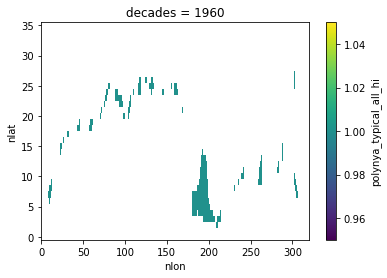

In [15]:
# keep just thickness metric for mask
poly_mask = ds_poly.polynya_typical_all_hi

# modify the mask for later calculations
poly_array = poly_mask.fillna(0)

# test plot
poly_mask.isel(decades=0).plot()

## Load CCAMLR regions for masks

In [16]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [17]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v9_02062025.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [18]:
# keep just masks of interest (MPAs, MPA planning areas)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Weddell_mpa_2','Ant_Peninsula_mpa','East_Ant_mpa']
ccamlr_masks = ds_ccamlr[ccamlr_in]

In [19]:
# mask of all mpas around whole continent
tmp1 = ccamlr_masks.Ross_mpa.fillna(0)
tmp2 = ccamlr_masks.Weddell_mpa.fillna(0)
tmp3 = ccamlr_masks.Weddell_mpa_2.fillna(0)
tmp4 = ccamlr_masks.Ant_Peninsula_mpa.fillna(0)
tmp5 = ccamlr_masks.East_Ant_mpa.fillna(0)

# add all together
tmp0 = tmp1 + tmp2 + tmp3 + tmp4 + tmp5

# create mask of the mpas
mpa_all = mask_ones.where(tmp0 > 0.0)

In [20]:
# now make xarray with all relevant masks as a new coordinate
ccamlr_all = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9', 'All_mpa']

ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9, mpa_all],
                         dim='region')
ccamlr_masks['region'] = ccamlr_all

## Load AEV Binned Data for masks

In [21]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [22]:
file_in = 'ecoindex_historical_future_bins.nc'
ds_bin = xr.open_dataset(path_in+file_in, decode_times=True)

In [23]:
# save the bin data
bins_region = ds_bin.aev_bins_region

In [24]:
# combine regional data into a single array for all three bins
data = bins_region

# load the three bins, set missing values to zero
tmp1 = data.isel(bin=0).fillna(0)
tmp2 = data.isel(bin=1).fillna(0)
tmp3 = data.isel(bin=2).fillna(0)

# for each of the three bins, re-label so that bin values are 1, 2, 3 and 0 is "other"
tmp1 = tmp1.where(tmp1 == 0, 3)
tmp2 = tmp2.where(tmp2 == 0, 2)

# add all three together
tmp0 = tmp1 + tmp2 + tmp3

# mask by where we have data or not
tmp0 = tmp0.where(ds_grid.REGION_MASK == 1)

# create mask of the high value points
bins_all = mask_ones.where(tmp0 > 0.0)
#bins_all.plot()

# now make xarray with all relevant masks as a new coordinate
bin_names = ['5pct','10pct','25pct','all']
bin_masks = xr.concat([data.isel(bin=0),data.isel(bin=1),data.isel(bin=2),bins_all], dim = 'bins')
bin_masks['bins'] = bin_names

# assign this info
bin_mask_regions = bin_masks

## Calculate stats for Table 2
- 4 zones: whole region, in polynyas, outside polynyas, in mpas
- 4 bin groups: all bins, bin 1, bin 2, bin 3
- Calculate area weighted average - SUM(TAREA * data)/SUM(TAREA)
- Calculate areaweighted standard deviation - https://www.statology.org/weighted-standard-deviation-excel/

In [25]:
# set AEV data to use
data_calc = eco_hemi
bin_mask = bin_mask_hemi
label = 'Hemispheric'
mpa = 'All_mpa'

NameError: name 'eco_hemi' is not defined

In [ ]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [ ]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

In [ ]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

In [ ]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

In [ ]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

In [ ]:
# calculate fractions of total areas
n = 0
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

In [ ]:
# calculate fractions of total areas
n = 1
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

In [ ]:
# calculate fractions of total areas
n = 2
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

## Regions

In [27]:
# set regional data to use
data_calc = eco_pd
bin_mask = bin_mask_regions

# mask TAREA for each region
tarea_eco = tarea.where((data_calc > 0) & (ccamlr_masks == 1))
tarea_poly = tarea.where((data_calc > 0) & (poly_array == 1) & (ccamlr_masks == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_array == 0) & (ccamlr_masks == 1))

## 2000s
- Run everything for 2000s

In [28]:
dec = 2000

### Weddell Sea

In [29]:
# set regional data to use
label = 'Weddell'
reg = 'mpa_plan_3_4'
mpa = 'All_mpa'

In [30]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Weddell fraction total area that is also:
polynyas
1.9131689727859054
mpas
43.264226065945536


In [31]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Weddell area weighted average AEV Index values:
avg overall
0.38159413731672864
avg IN polynya
0.5414384946923638
avg OUT polynya
0.3784763970267898


In [32]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Weddell standard deviation AEV Index values:
std overall
0.07015326502127552
std IN polynya
0.2640860373797988
std OUT polynya
0.06080721466121459


In [33]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin all:
Percent total area IN polynyas
7.600114036877542
Percent total area IN MPAs
80.9668728522317


In [34]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 5pct:
Percent total area IN polynyas
25.057502788867787
Percent total area IN MPAs
100.0


In [35]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 10pct:
Percent total area IN polynyas
4.975781082357492
Percent total area IN MPAs
100.0


In [36]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 25pct:
Percent total area IN polynyas
1.9815125555508568
Percent total area IN MPAs
67.61680831645442


### East Antarctica

In [37]:
# set regional data to use
label = 'EAntarctica'
reg = 'mpa_plan_7_mod'
mpa = 'All_mpa'

In [38]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

EAntarctica fraction total area that is also:
polynyas
6.9358788038217085
mpas
26.659079193348806


In [39]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

EAntarctica area weighted average AEV Index values:
avg overall
0.4692670710705091
avg IN polynya
0.5732611834356869
avg OUT polynya
0.46151660235705705


In [40]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

EAntarctica standard deviation AEV Index values:
std overall
0.10006853066478091
std IN polynya
0.19303383214246775
std OUT polynya
0.08952589759686955


In [41]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin all:
Percent total area IN polynyas
17.475387268004376
Percent total area IN MPAs
48.0517652500282


In [42]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 5pct:
Percent total area IN polynyas
53.008783360474474
Percent total area IN MPAs
64.5986448383163


In [43]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 10pct:
Percent total area IN polynyas
17.681041324122848
Percent total area IN MPAs
48.85223500852637


In [44]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 25pct:
Percent total area IN polynyas
5.086818316532631
Percent total area IN MPAs
42.02934079567146


### Ross Sea

In [45]:
# set regional data to use
label = 'Ross'
reg = 'mpa_plan_8'
mpa = 'All_mpa'

In [46]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Ross fraction total area that is also:
polynyas
9.082075701599825
mpas
44.31236743267837


In [47]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Ross area weighted average AEV Index values:
avg overall
0.40474790446482284
avg IN polynya
0.8221374985440818
avg OUT polynya
0.36305355299628006


In [48]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Ross standard deviation AEV Index values:
std overall
0.18459121236852005
std IN polynya
0.4354407720515688
std OUT polynya
0.13655607727556604


In [49]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin all:
Percent total area IN polynyas
46.14230719476415
Percent total area IN MPAs
74.17193961760475


In [50]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 5pct:
Percent total area IN polynyas
79.91114190279526
Percent total area IN MPAs
86.80571829134955


In [51]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 10pct:
Percent total area IN polynyas
66.48524048305197
Percent total area IN MPAs
87.247795664721


In [52]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 25pct:
Percent total area IN polynyas
29.727063597185598
Percent total area IN MPAs
66.31874451274406


### Amundsen Sea

In [53]:
# set regional data to use
label = 'Amundsen'
reg = 'mpa_plan_9'
mpa = 'All_mpa'

In [54]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Amundsen fraction total area that is also:
polynyas
1.4352926618528934
mpas
0.0


In [55]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Amundsen area weighted average AEV Index values:
avg overall
0.2817333653824983
avg IN polynya
0.6620001687984312
avg OUT polynya
0.27619594567894584


In [56]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Amundsen standard deviation AEV Index values:
std overall
0.06650502425110516
std IN polynya
0.43512870179015084
std OUT polynya
0.04311837564874195


In [57]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin all:
Percent total area IN polynyas
4.7397458674356265
Percent total area IN MPAs
0.0


In [58]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 5pct:
Percent total area IN polynyas
35.29577131459573
Percent total area IN MPAs
0.0


In [59]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 10pct:
Percent total area IN polynyas
0.0
Percent total area IN MPAs
0.0


In [60]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 25pct:
Percent total area IN polynyas
0.0
Percent total area IN MPAs
0.0


### Antarctic Peninsula

In [61]:
# set regional data to use
label = 'AntPeninsula'
reg = 'mpa_plan_1_mod'
mpa = 'All_mpa'

In [62]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

AntPeninsula fraction total area that is also:
polynyas
1.0075130078588723
mpas
38.24198740711008


In [63]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

AntPeninsula area weighted average AEV Index values:
avg overall
0.25851341289006247
avg IN polynya
0.5386581190068712
avg OUT polynya
0.2556621921149152


In [64]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

AntPeninsula standard deviation AEV Index values:
std overall
0.10378168610926068
std IN polynya
0.3855223173108108
std OUT polynya
0.0976422148032559


In [65]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin all:
Percent total area IN polynyas
3.693241405030982
Percent total area IN MPAs
63.9818922517429


In [66]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 5pct:
Percent total area IN polynyas
9.74597594720045
Percent total area IN MPAs
91.62450123992997


In [67]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 10pct:
Percent total area IN polynyas
3.868819298258832
Percent total area IN MPAs
82.69143401687256


In [68]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 25pct:
Percent total area IN polynyas
1.354054825220508
Percent total area IN MPAs
46.64836059175552


## 2090s
- Run everything for 2090s

In [69]:
dec = 2090

### Weddell Sea

In [70]:
# set regional data to use
label = 'Weddell'
reg = 'mpa_plan_3_4'
mpa = 'All_mpa'

In [71]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Weddell fraction total area that is also:
polynyas
1.889054868660138
mpas
58.23069813250451


In [72]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Weddell area weighted average AEV Index values:
avg overall
0.40967024301363403
avg IN polynya
0.5198390723914138
avg OUT polynya
0.4075490223564273


In [73]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Weddell standard deviation AEV Index values:
std overall
0.06540167213576878
std IN polynya
0.1319804863241269
std OUT polynya
0.06356154741127887


In [74]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin all:
Percent total area IN polynyas
6.712411464722558
Percent total area IN MPAs
62.74169280768377


In [75]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 5pct:
Percent total area IN polynyas
23.03629882813189
Percent total area IN MPAs
100.0


In [76]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 10pct:
Percent total area IN polynyas
7.744858560009021
Percent total area IN MPAs
86.56720427151855


In [77]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 25pct:
Percent total area IN polynyas
1.7763677083238747
Percent total area IN MPAs
44.78553691187911


### East Antarctica

In [78]:
# set regional data to use
label = 'EAntarctica'
reg = 'mpa_plan_7_mod'
mpa = 'All_mpa'

In [79]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

EAntarctica fraction total area that is also:
polynyas
11.062798110868782
mpas
37.40140195299428


In [80]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

EAntarctica area weighted average AEV Index values:
avg overall
0.4874929162323487
avg IN polynya
0.6532904060746627
avg OUT polynya
0.46686955369727784


In [81]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

EAntarctica standard deviation AEV Index values:
std overall
0.12662275120202018
std IN polynya
0.21611073096338987
std OUT polynya
0.11081920769159205


In [82]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin all:
Percent total area IN polynyas
31.797095342305077
Percent total area IN MPAs
63.2931581695617


In [83]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 5pct:
Percent total area IN polynyas
93.87297635475868
Percent total area IN MPAs
51.695606791753065


In [84]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 10pct:
Percent total area IN polynyas
27.625931753210008
Percent total area IN MPAs
64.74182330829143


In [85]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 25pct:
Percent total area IN polynyas
14.88558545833164
Percent total area IN MPAs
66.21392114670489


### Ross Sea

In [86]:
# set regional data to use
label = 'Ross'
reg = 'mpa_plan_8'
mpa = 'All_mpa'

In [87]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Ross fraction total area that is also:
polynyas
8.43697242452706
mpas
50.63061268800744


In [88]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Ross area weighted average AEV Index values:
avg overall
0.4583298444248865
avg IN polynya
0.7695388195376874
avg OUT polynya
0.42965384264974027


In [89]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Ross standard deviation AEV Index values:
std overall
0.1720995838577301
std IN polynya
0.3361307739803331
std OUT polynya
0.14836165096825452


In [90]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin all:
Percent total area IN polynyas
39.46974100082896
Percent total area IN MPAs
77.55902894680543


In [91]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 5pct:
Percent total area IN polynyas
45.11050518765455
Percent total area IN MPAs
85.00200825689024


In [92]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 10pct:
Percent total area IN polynyas
61.03970524888504
Percent total area IN MPAs
85.10577251243959


In [93]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 25pct:
Percent total area IN polynyas
30.676915573905784
Percent total area IN MPAs
72.56410796476706


### Amundsen Sea

In [94]:
# set regional data to use
label = 'Amundsen'
reg = 'mpa_plan_9'
mpa = 'All_mpa'

In [95]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Amundsen fraction total area that is also:
polynyas
1.9068806432825385
mpas
0.0


In [96]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Amundsen area weighted average AEV Index values:
avg overall
0.3842165527962068
avg IN polynya
0.6736607102597294
avg OUT polynya
0.3785899047214189


In [97]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Amundsen standard deviation AEV Index values:
std overall
0.07363962717783495
std IN polynya
0.3437507555073619
std OUT polynya
0.05806725116952932


In [98]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin all:
Percent total area IN polynyas
9.596446559495096
Percent total area IN MPAs
0.0


In [99]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 5pct:
Percent total area IN polynyas
40.69461657902843
Percent total area IN MPAs
0.0


In [100]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 10pct:
Percent total area IN polynyas
2.8289107146475003
Percent total area IN MPAs
0.0


In [101]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 25pct:
Percent total area IN polynyas
0.0
Percent total area IN MPAs
0.0


### Antarctic Peninsula

In [102]:
# set regional data to use
label = 'AntPeninsula'
reg = 'mpa_plan_1_mod'
mpa = 'All_mpa'

In [103]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg,decades=dec).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

AntPeninsula fraction total area that is also:
polynyas
0.5946462018259535
mpas
38.18893278453852


In [104]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg,decades=dec)*data_calc.sel(decades=dec)).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

AntPeninsula area weighted average AEV Index values:
avg overall
0.26505989696359045
avg IN polynya
0.7971050365256062
avg OUT polynya
0.26187718487262135


In [105]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg,decades=dec)*(data_calc.sel(decades=dec)-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg,decades=dec).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg,decades=dec).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

AntPeninsula standard deviation AEV Index values:
std overall
0.09210284155290493
std IN polynya
0.6793319013503922
std OUT polynya
0.08178963609919661


In [106]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin all:
Percent total area IN polynyas
2.4188973369595286
Percent total area IN MPAs
83.25886926806804


In [107]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 5pct:
Percent total area IN polynyas
12.966917590573843
Percent total area IN MPAs
86.7417971058483


In [108]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 10pct:
Percent total area IN polynyas
0.0
Percent total area IN MPAs
80.25775566360598


In [109]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask.sel(decades=dec) == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg,decades=dec).where(bin_mask.sel(decades=dec).isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 25pct:
Percent total area IN polynyas
0.0
Percent total area IN MPAs
83.00724415415489
